<a href="https://colab.research.google.com/github/himanshu-tawra/COVID-19-Detector-Flask-App-from-Chest-X-ray-Images-with-Keras-and-Deep-Learning/blob/master/VGG16_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.dropbox.com/sh/c2uaggwlb2hosof/AABAu2Uv3u81izc4rWk9zxgna?dl=0

--2020-11-05 22:54:03--  https://www.dropbox.com/sh/c2uaggwlb2hosof/AABAu2Uv3u81izc4rWk9zxgna?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.1, 2620:100:6019:1::a27d:401
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/c2uaggwlb2hosof/AABAu2Uv3u81izc4rWk9zxgna [following]
--2020-11-05 22:54:03--  https://www.dropbox.com/sh/raw/c2uaggwlb2hosof/AABAu2Uv3u81izc4rWk9zxgna
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce64e410255350987eb69c40c41.dl.dropboxusercontent.com/zip_download_get/AmAuVJ9J1Cj-cwlRh13TLOWwNxs54zi7EUflnqHq3SsRX5LwG-yVZrYKxYYxn4Anv0mZJRxLBmTSZKqLPDY0n9WQWOxwQTFL0WfMb9uIQP_MHA [following]
--2020-11-05 22:54:04--  https://uce64e410255350987eb69c40c41.dl.dropboxusercontent.com/zip_download_get/AmAuVJ9J1Cj-cwlRh13TLOWwNxs54zi7EUflnqHq3SsRX5LwG-yVZrYKxYYxn4Anv0mZJRxLBmTSZKqLPDY0

In [2]:
!unzip AABAu2Uv3u81izc4rWk9zxgna?dl=0

Archive:  AABAu2Uv3u81izc4rWk9zxgna?dl=0
mapname:  conversion of  failed
   creating: Val/
   creating: Test/
   creating: Train/
   creating: Val/Covid/
   creating: Test/Covid/
   creating: Val/Normal/
   creating: Train/Covid/
   creating: Test/Normal/
   creating: Train/Normal/
 extracting: Train/Covid/AR-2.jpg    
 extracting: Train/Covid/AR-1.jpg    
 extracting: Test/Covid/paving.jpg   
 extracting: Val/Covid/d009d61f.jpg  
 extracting: Val/Covid/e1446fe8.jpg  
 extracting: Val/Covid/d9d6ca9a.jpg  
 extracting: Val/Covid/f6d980a0.jpg  
 extracting: Val/Covid/ec083e35.jpg  
 extracting: Test/Covid/f8335316.jpg  
 extracting: Test/Covid/f6575117.jpg  
 extracting: Test/Covid/f64132c8.jpg  
 extracting: Train/Covid/5782ae15.jpg  
 extracting: Train/Covid/bb0e626a.jpg  
 extracting: Train/Covid/82a78c13.jpg  
 extracting: Train/Covid/a361d7b7.jpg  
 extracting: Train/Covid/1052b0fe.jpg  
 extracting: Train/Covid/a2eba651.jpg  
 extracting: Train/Covid/bd10d5e2.jpg  
 extracting: Tra

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.applications.vgg16 import VGG16
import keras

In [2]:
IMAGE_SIZE = [224,224]

In [3]:
vgg = VGG16(input_shape= IMAGE_SIZE + [3] , weights='imagenet',include_top=False)

In [4]:
for layer in vgg.layers:
  layer.trainable = False

In [5]:
vgg_output = vgg.output

In [6]:
flatten = Flatten()(vgg_output)
dense_layer1 = Dense(activation= 'relu',units=256)(flatten)
dense_layer2 = Dense(activation = 'relu',units = 128)(dense_layer1)
output_layer = Dense(2,activation='softmax')(dense_layer2)

In [7]:
model = Model(inputs = vgg.input,outputs = output_layer)

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-6),  # Low learning rate
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [10]:
training_data_gen = ImageDataGenerator(
    rescale = 1./255.,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True
)

In [11]:
val_data_gen = ImageDataGenerator(
    rescale = 1./255.
)

In [12]:
training_set = training_data_gen.flow_from_directory(
    'Train/',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)

Found 251 images belonging to 2 classes.


In [13]:
val_set = val_data_gen.flow_from_directory(
    'Val/',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)

Found 70 images belonging to 2 classes.


In [14]:
r = model.fit(
    training_set,
    epochs = 100,
    validation_data = val_set,
    validation_steps = len(val_set),
    steps_per_epoch = len(training_set)
    
)

Epoch 1/100
8/8 [==============================] - 10s 1s/step - loss: 0.7113 - accuracy: 0.4900 - val_loss: 0.7071 - val_accuracy: 0.5143
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.6821 - accuracy: 0.5339 - val_loss: 0.6761 - val_accuracy: 0.5714
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.6556 - accuracy: 0.6215 - val_loss: 0.6491 - val_accuracy: 0.7000
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 0.6315 - accuracy: 0.7371 - val_loss: 0.6237 - val_accuracy: 0.7714
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 0.6133 - accuracy: 0.8048 - val_loss: 0.5990 - val_accuracy: 0.8714
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 0.5940 - accuracy: 0.8127 - val_loss: 0.5751 - val_accuracy: 0.8714
Epoch 7/100
8/8 [==============================] - 9s 1s/step - loss: 0.5726 - accuracy: 0.8446 - val_loss: 0.5525 - val_accuracy: 0.8857
Epoch 8/100
8/8 [================

In [15]:
test_pred = []
test_actual = []
label_dict = {
    0 : "Covid",
    1 : "Normal"
}
rescaled_images = []

In [16]:
def image_preprocessing(path):
  for filename in os.listdir(path):

    if path == 'Test/Covid':
      filepath = os.path.join(path,filename)
      test_image = image.load_img(filepath,target_size=(224,224))
      image_array = image.img_to_array(test_image)
      image_array = np.expand_dims(image_array,axis = 0)
      rescaled_image = image_array/255. 
      predicted_image = model.predict(rescaled_image)
      predicted_image = label_dict[predicted_image.argmax()]
      test_pred.append(predicted_image)
      test_actual.append('Covid')

    elif path == 'Test/Normal':
      filepath = os.path.join(path,filename)
      test_image = image.load_img(filepath,target_size=(224,224))
      image_array = image.img_to_array(test_image)
      image_array = np.expand_dims(image_array,axis = 0)
      rescaled_image = image_array/255. 
      predicted_image = model.predict(rescaled_image)
      predicted_image = label_dict[predicted_image.argmax()]
      test_pred.append(predicted_image)
      test_actual.append('Normal')




In [17]:
covid_path = 'Test/Covid'
normal_path = 'Test/Normal'

In [18]:
image_preprocessing(covid_path)
image_preprocessing(normal_path)


In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
cm = confusion_matrix(test_pred,test_actual)

In [21]:
print(cm)

[[35  0]
 [ 0 35]]


In [22]:
import seaborn as sns


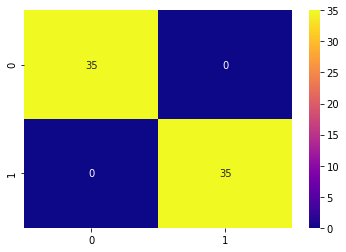

In [23]:
sns.heatmap(cm,cmap = 'plasma',annot = True)

In [24]:
from sklearn.metrics import precision_recall_fscore_support


In [25]:
prf = precision_recall_fscore_support(test_actual,test_pred,labels = ['Covid','Normal'])

In [26]:
print(prf)

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([35, 35]))


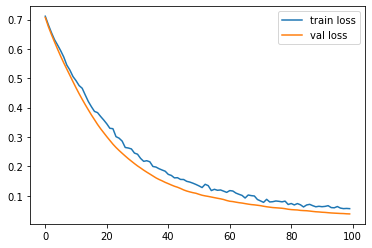

In [27]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'val loss')
plt.legend()
plt.show()

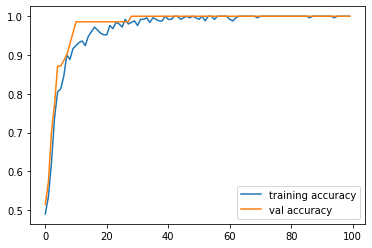

In [28]:
plt.plot(r.history['accuracy'],label = 'training accuracy')
plt.plot(r.history['val_accuracy'],label = 'val accuracy')
plt.legend()
plt.show()

In [29]:
model.save('vgg16_model.h5')